In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


# Introduction

This notebook explains how I use Fourier transform to extract features of accelerometer signals for stand still.

In [2]:
from utils.fourier import apply_fft_df, apply_fft_df_batch

First, I have build a custom function to process collected accelerometer data in batch.

The apply_fft_df_batch function automatically:
1. read csv into dataframe in batch
2. generate an acceleration magnitude variable: df['accel.mag'] = np.sqrt(df['accel.x']**2 + df['accel.y']**2 + df['accel.z']**2)
3. Slices data into 1 second segments, by setting: window_duration=1, sampling_rate=50
4. Calculate the amplitude of different frequencies within the segment
5. Store the features into a dataframe

# Use Fourier transform to extract features of standing still signals

I then use the apply_fft_df_batch function to obtain features of standing still data. These features will be used to recognise segments, in which no movements have occurred.

In [3]:
results = apply_fft_df_batch('./data/raw_data/', keyword='standstill', window_duration=1, sampling_rate=50, plot=False)

standstill-20240919-16h50.csv contains needed columns. Processing...
standstill-20240921-15h41.csv contains needed columns. Processing...


The results dataframe contains Fourier transform features for all segments. 

In [4]:
results.head(30)

,Frequency_Hz,Amplitude,Window,file_name
0,0.0,50.986063,0,standstill-20240919-16h50.csv
1,1.0,0.072584,0,standstill-20240919-16h50.csv
2,2.0,0.053702,0,standstill-20240919-16h50.csv
3,3.0,0.022112,0,standstill-20240919-16h50.csv
4,4.0,0.025506,0,standstill-20240919-16h50.csv
5,5.0,0.015025,0,standstill-20240919-16h50.csv
6,6.0,0.001947,0,standstill-20240919-16h50.csv
7,7.0,0.015556,0,standstill-20240919-16h50.csv
8,8.0,0.011883,0,standstill-20240919-16h50.csv
9,9.0,0.005405,0,standstill-20240919-16h50.csv


Then, I obtained the statistics of amplitudes of different frequencies and export it into a csv.

In [5]:
# Group by the 'Frequency (Hz)' and aggregate the amplitude
baseline_agg_results = results.groupby('Frequency_Hz').agg(
    mean_amp=('Amplitude', 'mean'),
    std_amp=('Amplitude', 'std'),
    min_amp=('Amplitude', 'min'),
    max_amp=('Amplitude', 'max')
).reset_index()

# Display the result
print(baseline_agg_results)

baseline_agg_results.to_csv('./data/fourier_transform/standstill-fft-results.csv', index=False)

    Frequency_Hz   mean_amp   std_amp    min_amp    max_amp
0            0.0  50.929353  0.122308  50.470849  51.295599
1            1.0   0.075142  0.039684   0.005109   0.296233
2            2.0   0.050548  0.028064   0.000252   0.178287
3            3.0   0.032716  0.019494   0.001493   0.161021
4            4.0   0.022261  0.012380   0.000092   0.097713
5            5.0   0.014932  0.008648   0.000220   0.068999
6            6.0   0.009307  0.006039   0.000182   0.048356
7            7.0   0.009167  0.005305   0.000108   0.047355
8            8.0   0.010316  0.005782   0.000233   0.047606
9            9.0   0.010789  0.006342   0.000188   0.041395
10          10.0   0.010702  0.006026   0.000061   0.045300
11          11.0   0.009472  0.005593   0.000170   0.040384
12          12.0   0.006000  0.003496   0.000153   0.025395
13          13.0   0.005669  0.003295   0.000142   0.023848
14          14.0   0.007767  0.004653   0.000215   0.033409
15          15.0   0.007751  0.004392   

We can see that the highest amplitude is at 0 Hz, which is the constant of Fourier transform. The amplitudes of the rest Hz bands are created by noises and very minor movements. 

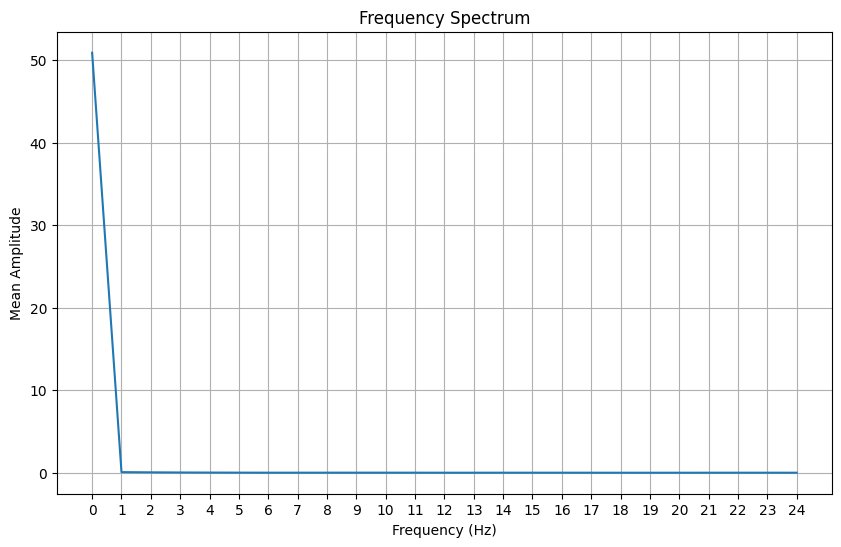

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(baseline_agg_results['Frequency_Hz'], baseline_agg_results['mean_amp'])
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.xticks(np.linspace(0, 24, 25))
plt.ylabel('Mean Amplitude')
plt.grid(True)
plt.show()

# Use extracted feature to detect handflapp: an example

Then, we can use the amplitudes from 1 to 24 Hz bands to detect movement above this noise threshold. I decided to use the maximum amplitude of all frequncy bands as the threshold, because all of these amplitude values are created by noises. Here is an example.

In [7]:
# Import handflapping data
fname = "handflapping-20240915-12h46.csv"
df = pd.read_csv('./data/raw_data/' + fname)

df = df.iloc[500:-500].reset_index(drop=True) # Drop the first and last 500 rows (10 seconds) to remove noises caused by button pressings
df['accel.mag'] = np.sqrt(df['accel.x']**2 + df['accel.y']**2 + df['accel.z']**2) # Create a new column for acceleration magnitude

In [8]:
df.head()

,timestamp,accel.x,accel.y,accel.z,accel.mag,accel.diff,comp.x,comp.y,comp.z,comp.dx,comp.dy,comp.dz,comp.heading
0,1.726397e+12,-0.965210,0.287720,-0.093262,1.011489,0.031616,191,668,351,-4,-170,91,178.652113
1,1.726397e+12,-0.965210,0.287720,-0.093262,1.011489,0.031616,191,668,351,-4,-170,91,178.652113
2,1.726397e+12,-0.998779,0.306274,-0.071899,1.047155,0.043823,185,653,354,-10,-185,94,176.905942
3,1.726397e+12,-0.998779,0.306274,-0.071899,1.047155,0.043823,185,653,354,-10,-185,94,176.905942
4,1.726397e+12,-0.998779,0.306274,-0.071899,1.047155,0.043823,185,653,354,-10,-185,94,176.905942


We apply Fourier transform to all 1 second segements of the handflapping data.

In [9]:
# Apply Fourier transform to all 1 second segements of the data
handflapping_fft_results = apply_fft_df(df=df, file_name=fname, window_duration=1, sampling_rate=50, plot=False, column='accel.mag')

In [10]:
# The amplitude and frequency of the first 30 peaks
handflapping_fft_results.head(30)

,Frequency_Hz,Amplitude,Window,file_name
0,0.0,51.217650,0,handflapping-20240915-12h46.csv
1,1.0,0.385101,0,handflapping-20240915-12h46.csv
2,2.0,0.377686,0,handflapping-20240915-12h46.csv
3,3.0,0.164814,0,handflapping-20240915-12h46.csv
4,4.0,0.082408,0,handflapping-20240915-12h46.csv
5,5.0,0.064289,0,handflapping-20240915-12h46.csv
6,6.0,0.046396,0,handflapping-20240915-12h46.csv
7,7.0,0.048566,0,handflapping-20240915-12h46.csv
8,8.0,0.025855,0,handflapping-20240915-12h46.csv
9,9.0,0.075516,0,handflapping-20240915-12h46.csv


We mark any handflapping segments that have amplitudes above the threshold as movement detected.

In [11]:
df['detected'] = np.repeat(False, len(df))
n_windows = max(handflapping_fft_results['Window'])
baseline_amplitudes = baseline_agg_results[-24:]['max_amp'].to_numpy()
baseline_amplitudes = np.repeat(max(baseline_agg_results[-24:]['max_amp']), 24)

for i in range(n_windows + 1):
    window_results = handflapping_fft_results[handflapping_fft_results['Window'] == i]
    window = df[df['Window'] == i]
    window_amplitudes = (window_results[-24:]['Amplitude']).to_numpy()
    # print(window_amplitudes > baseline_amplitudes)
    if any(window_amplitudes > baseline_amplitudes):
        df.loc[df['Window'] == i, 'detected'] = True

In [12]:
# Drop rows with NaN values in the 'Window' column, i.e., rows that are not part of any window
df = df.dropna(subset=['Window']).reset_index(drop=True)
df.loc[:, ['timestamp', 'accel.mag', 'Window', 'detected']].head(30)

,timestamp,accel.mag,Window,detected
0,1.726397e+12,1.011489,0.0,True
1,1.726397e+12,1.011489,0.0,True
2,1.726397e+12,1.047155,0.0,True
3,1.726397e+12,1.047155,0.0,True
4,1.726397e+12,1.047155,0.0,True
5,1.726397e+12,1.047155,0.0,True
6,1.726397e+12,1.046052,0.0,True
7,1.726397e+12,1.046052,0.0,True
8,1.726397e+12,1.046052,0.0,True
9,1.726397e+12,1.046052,0.0,True
